In [182]:
!pip install textblob


In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from textblob import TextBlob
from wordcloud import WordCloud
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score



In [184]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [185]:
# Read dataset
data = pd.read_csv("spam.csv", encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [186]:
# Drop unnecessary columns
data = data.drop(columns=data.columns[2:5])
data.rename(columns={'v1': 'Label', 'v2': 'Text'}, inplace=True)

In [187]:
# Data preprocessing - remove unwanted characters
def clean_text(text):
    cleaned = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    cleaned = re.sub(r'\s+', ' ', cleaned)  # Remove extra spaces
    return cleaned.lower().strip()

data['Text'] = data['Text'].apply(clean_text)

In [188]:
# Check for missing values and duplicates
print("Missing values:\n", data.isnull().sum())
print("Duplicate rows:", data.duplicated().sum())

Missing values:
 Label    0
Text     0
dtype: int64
Duplicate rows: 444


In [189]:
# Drop duplicates
data.drop_duplicates(inplace=True)

In [190]:
# Data summary
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5128 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5128 non-null   object
 1   Text    5128 non-null   object
dtypes: object(2)
memory usage: 120.2+ KB


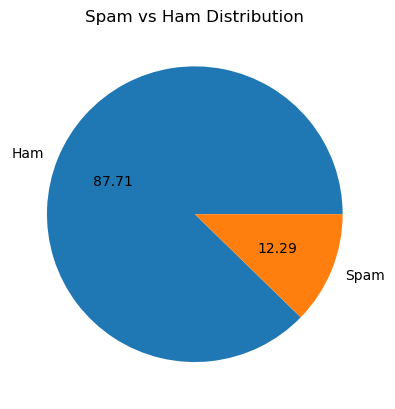

In [191]:
# Data visualization
plt.pie(data['Label'].value_counts(), labels=['Ham', 'Spam'], autopct="%0.2f")
plt.title("Spam vs Ham Distribution")
plt.show()

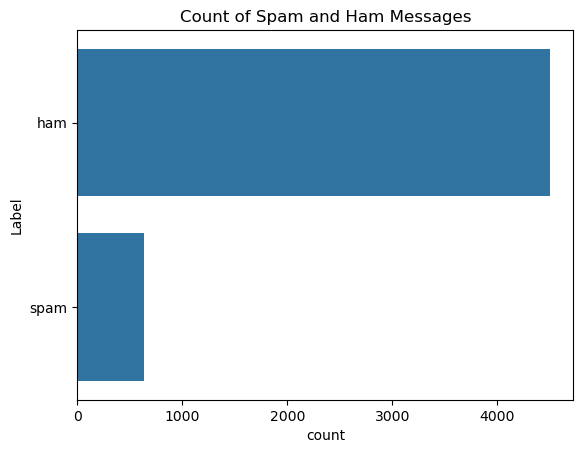

In [192]:
sns.countplot(data['Label'])
plt.title("Count of Spam and Ham Messages")
plt.show()


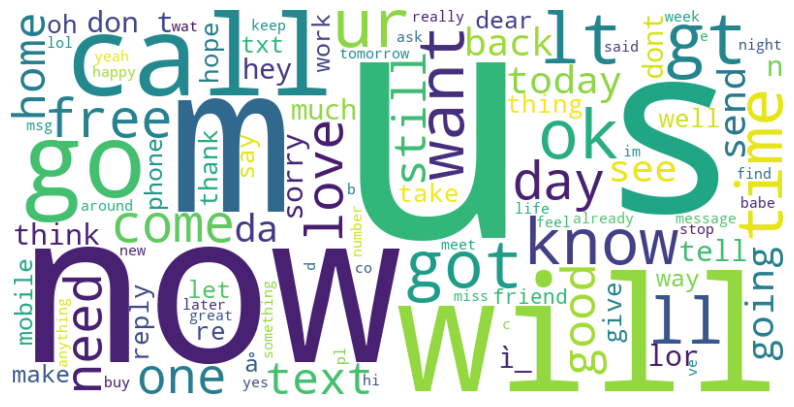

In [193]:
# Generate WordCloud for frequent words
all_words = " ".join(data['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [194]:
# Tokenize and count characters, words, sentences
nltk.download('punkt')
data['char_count'] = data['Text'].apply(len)
data['word_count'] = data['Text'].apply(lambda x: len(nltk.word_tokenize(x)))
data['sentence_count'] = data['Text'].apply(lambda x: len(nltk.sent_tokenize(x)))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [195]:
# Encode labels: 'ham' = 0, 'spam' = 1
data['Spam_Label'] = data['Label'].map({'ham': 0, 'spam': 1})


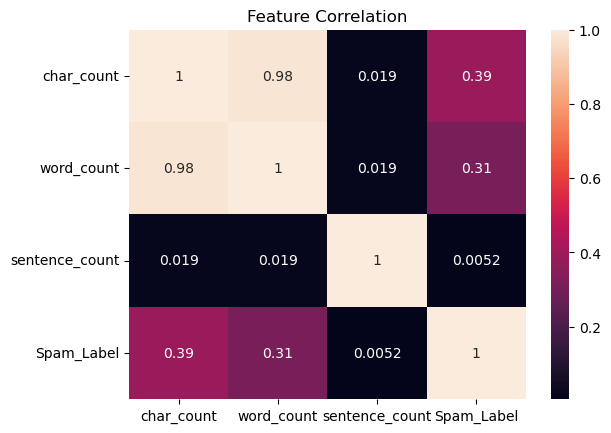

In [196]:
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=[np.number])

# Visualize correlation matrix
sns.heatmap(numeric_data.corr(), annot=True)
plt.title("Feature Correlation")
plt.show()


In [197]:
# Prepare features and labels for model training
X = data['Text']
y = data['Spam_Label']

In [198]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [199]:
# TF-IDF Vectorization
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [200]:
# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)


MultinomialNB()

In [201]:
# Predictions and evaluation
X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_pred = nb_model.predict(X_test_tfidf)


In [202]:
# Evaluate model performance
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Naive Bayes Accuracy: 0.949317738791423
Confusion Matrix:
 [[891   0]
 [ 52  83]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       891
           1       1.00      0.61      0.76       135

    accuracy                           0.95      1026
   macro avg       0.97      0.81      0.87      1026
weighted avg       0.95      0.95      0.94      1026



In [203]:
# Logistic Regression Model
log_model = LogisticRegression()
log_model.fit(X_train_tfidf, y_train)
y_log_pred = log_model.predict(X_test_tfidf)


In [204]:
# Logistic Regression Evaluation
log_accuracy = accuracy_score(y_test, y_log_pred)
log_roc_auc = roc_auc_score(y_test, y_log_pred)
print(f"Logistic Regression Accuracy: {log_accuracy} | ROC AUC: {log_roc_auc}")

Logistic Regression Accuracy: 0.9649122807017544 | ROC AUC: 0.8729517396184062
